**Object Detection with OpenCV and SSD Tensorflow model on images and video**

In this notebook we will demonstrate object detection with OpenCV and a simple SSD model called inceptionv2.

# Set Libraries

In [1]:
import numpy as np
import cv2 as cv2
import os


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Routine to fix colors in image
def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Read Labels #
In this section we will read the labels. We will also create a COLORS array which will give a different color for each label. 

In [2]:
#Declare Labels
LABELS = ["background", "person", "bicycle", "car", "motorcycle",
    "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
    "unknown", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "unknown", "backpack",
    "umbrella", "unknown", "unknown", "handbag", "tie", "suitcase", "frisbee", "skis",
    "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
    "surfboard", "tennis racket", "bottle", "unknown", "wine glass", "cup", "fork", "knife",
    "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
    "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "unknown", "dining table",
    "unknown", "unknown", "toilet", "unknown", "tv", "laptop", "mouse", "remote", "keyboard",
    "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "unknown",
"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush" ]

print ("number of labels", len(LABELS))
np.random.seed(42) #Set seed so that we get the same results everytime
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

number of labels 91


# Read Model Files #
The DNN module from CV2 supports reading of tensorflow trained object detection models. We need to load the weight and config for this. For more on this topic refer to 
https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API

In [3]:
weights="model_data/ssd_inception_v2_coco_2017_11_17_frozen_inference_graph.pb"
config="model_data/ssd_inception_v2_coco_2017_11_17.pbtxt"

#weights="model_data/ssd_mobilenet_v1_coco_2017_11_17_frozen_inference_graph.pb"
#config="model_data/ssd_mobilenet_v1_coco_2017_11_17.pbtxt"

In [4]:
#Read the model and create a Net internally with the model
net = cv2.dnn.readNetFromTensorflow(weights, config)

# Read Input Image #
We will now read the file and process it. 

In [5]:
img = cv2.imread('images/dining_table.jpg')

We will the identify the height and width of the image

In [6]:
(H, W) = img.shape[:2]
print (H,W)

500 500


# Process the Image

In [7]:
#convert the image to a blob for processing. swap RB enable the issue with CV2 reading files as BGR
blob = cv2.dnn.blobFromImage(img, swapRB=True, crop=False)

In [8]:
#Set the input
net.setInput(blob)

In [9]:
#Process it to create boxes. 
boxes = net.forward()

There will be 100 detections. The detection will include the classID, confidence and parameters of the box. 

1. ClassID
2. Probability or Confidence
3. Normalized min_x
4. Normalized min_y
5. Normalized max_x
6. Normalised max_y

In [10]:
print (boxes.shape)

(1, 1, 100, 7)


In [11]:
for i in range(0, boxes.shape[2]):
    classID = int(boxes[0, 0, i, 1]) #ClassID
    confidence = boxes[0, 0, i, 2]  #Confidence
    #print ("Confidence", confidence)
    if confidence > 0.7: #Set a threshold beyond which you want detections        
        #Box coordinates are normalised. Multiply with actual rows and columns to get
        #actual dimensions
        
        min_x=int(boxes[0, 0, i, 3]*W)
        min_y=int(boxes[0, 0, i,4]*H)
        max_x=int(boxes[0, 0, i,5]*W)
        max_y=int(boxes[0, 0, i,6]*H)
        #Integer the colors
        color = COLORS[classID]
        color = [int(c) for c in color]
        #print (LABELS[classID])
        #Make rectangle for the box
        cv2.rectangle(img, (min_x, min_y), (max_x, max_y), color, 6)
        #Text to display includes the Label and confidence
        text = "{}: {:.2f}".format(LABELS[classID], confidence)
        cv2.putText(img, text, (min_x, min_y - 10),
				cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

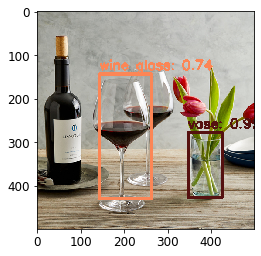

In [12]:
plt.imshow(fixColor(img))

# Video Processing #

We will first declares the output video which will be create. We use in-built CV2 create an MP4 video, with 30 fps and frame size 640*480

In [13]:
writer = cv2.VideoWriter("output.mp4", 
                         cv2.VideoWriter_fourcc(*"MP4V"), 30,(640,480))

In [14]:
#Create a new video stream and get total frame count
video_stream = cv2.VideoCapture('/cxldata/dlcourse/overpass.mp4')
total_frames=video_stream.get(cv2.CAP_PROP_FRAME_COUNT)
total_frames

812.0

In [15]:
pip install imutils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [16]:
from imutils.video import FPS
#Track FPS on frames per second
fps = FPS().start()
frameCnt=0
#while(frameCnt < 90):
while(frameCnt < total_frames-1):
    
    frameCnt+=1
    #print ("frame", frameCnt)
    ret, frame = video_stream.read()
    (H, W) = frame.shape[:2]
    
    #convert the image to a blob for processing. swap RB enable the issue with CV2 reading files as BGR
    blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)
    #Set the input
    net.setInput(blob)
    #Process it to create boxes. 
    boxes = net.forward()
    for i in range(0, boxes.shape[2]):
        classID = int(boxes[0, 0, i, 1]) #ClassID
        confidence = boxes[0, 0, i, 2]  #Confidence
        #print ("Confidence", confidence)
        if confidence > 0.1: #Set a threshold beyond which you want detections        
            #Box coordinates are normalised. Multiply with actual rows and columns to get
            #actual dimensions

            min_x=int(boxes[0, 0, i, 3]*W)
            min_y=int(boxes[0, 0, i,4]*H)
            max_x=int(boxes[0, 0, i,5]*W)
            max_y=int(boxes[0, 0, i,6]*H)
            #Integer the colors
            color = COLORS[classID]
            color = [int(c) for c in color]
            #print (LABELS[classID], color)
            #Make rectangle for the box
            cv2.rectangle(frame, (min_x, min_y), (max_x, max_y), color, 6)
            #Text to display includes the Label and confidence
            text = "{}: {:.2f}".format(LABELS[classID], confidence)
            cv2.putText(frame, text, (min_x, min_y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
    writer.write(cv2.resize(frame, (640,480)))
    fps.update() #update fps

    
fps.stop()

print("FPS: {:.3f}".format(fps.fps()))

#Release video object
video_stream.release()
writer.release()
    
    

FPS: 1.596
